In [1]:
!git clone https://github.com/Damowerko/ese2000-dynamical-systems.git
import sys
if sys.path[-1] != "./ese2000-dynamical-systems/":
    sys.path.append('./ese2000-dynamical-systems/')
from ese2000_dynamical.config import Config
from ese2000_dynamical.track import load_track, Track
from ese2000_dynamical.simulator import Simulator, dynamics_ca

fatal: destination path 'ese2000-dynamical-systems' already exists and is not an empty directory.


In [2]:
from pathlib import Path
import matplotlib.style
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from IPython.core.display_functions import clear_output
from Critic import Critic
import os


matplotlib.style.use("seaborn-v0_8-colorblind")
plt.rcParams["figure.dpi"] = 150

data_path = Path("./ese2000-dynamical-systems/data")
figure_path = Path("figures")

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

In [3]:
x_expert = torch.Tensor(np.load(data_path / "states.npy")).float().to(device)
x_sample = x_expert[5]
track = load_track(data_path / "track.npz")

In [4]:
def plot_vs_expert(x, x_label: str, x_expert, track: Track):
    plt.figure()
    track.plot()
    plt.grid(True)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.plot(x_expert[:, 0], x_expert[:, 1], "--", label="Expert")
    plt.plot(x[:, 0], x[:, 1], "-", label=x_label)
    plt.legend(loc="upper right", framealpha=1.0)

In [5]:
POLICY_INPUT_DIM = Critic.STATE_LOOK_AHEAD_DIM

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(POLICY_INPUT_DIM, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 2)
        init.uniform_(self.fc4.weight, a=-1e-6, b=1e-6)

    def forward(self, normalized_state_look_ahead):
        x = normalized_state_look_ahead
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        return x

In [6]:

Q = Critic("./models/q_model.pth", device=device)

if os.path.exists("./models/policy_model.pth"):
    policy  = torch.jit.load("./models/policy_model.pth").to(device)
    print("Model already trained and loaded from file 'models/policy_model.pth'")
    print("If you would like to retrain your model, delete './models' and run this cell again.")
else:
    policy = Policy().to(device)

# TODO: REMOVE THIS
policy = Policy().to(device)

torch.Size([800, 4])
The normalized_state_look_ahead dim (input dim for policy) is 44
Model already trained and loaded from file 'models/policy_model.pth'
If you would like to retrain your model, delete './models' and run this cell again.


In [7]:
policy_opt = torch.optim.Adam(policy.parameters(), lr=2e-5, maximize=True)

Episode 101	 Policy loss: -2.4522714614868164	 Trajectory size: 5


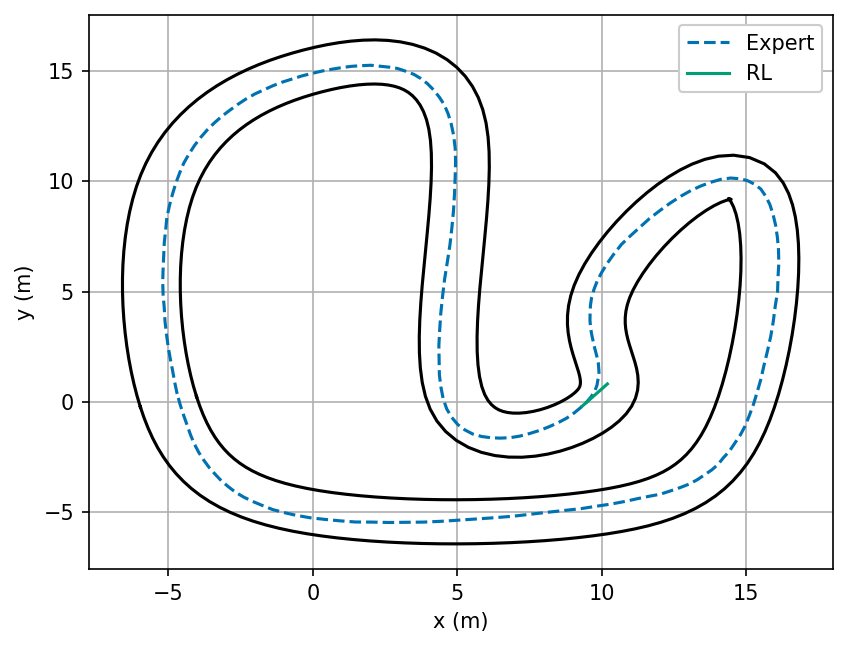

  2%|▏         | 178/10000 [00:03<03:32, 46.15it/s]


KeyboardInterrupt: 

In [8]:
from tqdm import trange

torch.set_printoptions(precision=3)
episodes = 10_000
gamma = 0.99
policy_loss = 0

policy.train()
for episode in trange(episodes):


    policy_opt.zero_grad()
    policy_loss, predicted_trajectory = Q.criticize_policy(policy)
    policy_loss.backward()
    policy_opt.step()

    if episode % 100 == 0:
        clear_output()
        print(f'Episode {episode+1}\t Policy loss: {policy_loss}\t Trajectory size: {predicted_trajectory.shape[0]}')
        plot_vs_expert(predicted_trajectory.cpu().numpy(), 'RL', x_sample.detach().cpu().numpy() , track)
        plt.show()

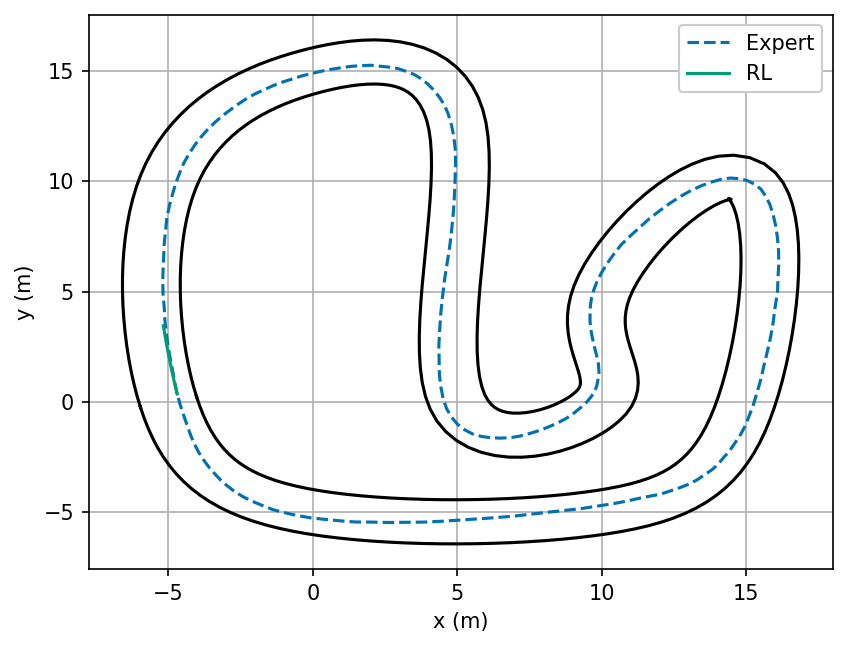

In [9]:
_, _, predicted_trajectory = Q.run_policy(policy, random_start=False, max_timesteps=200)
plot_vs_expert(predicted_trajectory.cpu().numpy(), 'RL', x_sample.detach().cpu().numpy() , track)
plt.show()